# ABCD - It is a technique used for detecting the probability of a lesion being a melanoma.

### A - Asymmetry / Asimetría
The asymmetry of the lesion. The more asymmetrical the more probable it is of being melanoma. The developed code for detecting symmetry is a product of this project. We have not tested how accurate it is nor do we recommend it's use, until it has been more properly tested. It is experimental, however given the constraints of this project it is considered to be functional. A simple explanation will be offered:

El código de asimetría es producto de esta investgación. No se ha probado, por lo cual no se recomienda el uso de este hasta que se haya probado de una manera más completa.

It is assumed that a nevi(e.g. mole) should be as round as possible [1]. Ideally it is a circle. Therefore we idealize this, and compare the picture given to a circle. For this we give a score, if this score is too high we rate the object as not symmetric. For that we must first apply a threshold, do that we only have two values, 0 for healthy skin and 255 for non-healthy (lesion) skin. Which corresponds to black and white respectively. 

Se asume que un nevo(lunar) debe ser lo más circular posible[1]. Idealmente un circulo. Por lo cual se idealiza este concepto y se compara la image con un círculo. Esto se hace por medio de un puntaje. Si este puntaje es muy alto se dice que el objeto no es simétrico. Para lograr esto primeramente se le debe aplicar un umbral a la imagen de forma que la piel sana tenga un valor de 0 y la piel no sana (lesión) tenga un valor de 255. Lo cual corresponde a negro y blanco respectivamente.


Examples, Ejemplos:
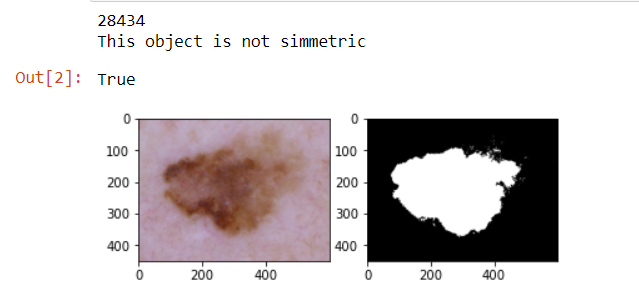

We used Otsu's threshold, for it is less dependant of the skin tone and it´s capable of adapting itself [2]. This is done in the effor to maintain the code relevant and keep maintainance low. Once Otsu is applied the largest threshold is selected. This threshold is then filled in, as to remove any non-white pixel found inside it. Furthermore all other thresholds are remove as to not cause problems in the next step. (This can be observed in the figure)

Se utilizo el umbral de Otsu, ya que este es tiene menos dependencia del tono de piel y es capaz de adaptarse[2]. Esto con el proposito de mantener el código relevante y que necesite poco mantenimiento. Una vez que ya se aplicó Otsu, se selecciona el umbral de mayor tamaño, suponiendo que este representa la mayor area de la lesión. Se rellena el umbral seleccionado, de manera que no tenga ningun pixel negro dentro de sí. Con esto listo, se deshace de los demás umbrales para que estos no provoquen problemas en la siguiente etapa. (En la figura se puede observar esto)

The next step consists of two parts, first the image is rotated on its centre. So that no one specific angle is favoured. Once an image is rotated a centre along the x and y axis are calculated. To do this we get the aproximate centre of each column and row of the image. Then  the mean of all those values is taken and we subtract both sides all along the edge. The result of all these subctractions are added to a global counter that will determine wether a shape is symmetryc or not. The higher the counter the less symmetryc a lesion is considered 

El siguiente paso consiste de dos partes, primero se gira la imagen con respecto a su centro. De manera que se de una vuelta completa, esto con el objetivo de poder analisar la imagen desde diferentes simetrías de forma que no se prefiera una sobre otra. Segundamente se calcula un centro tanto en el eje y como x. De forma que se pueda dividir la imagen a lo largo de los dos ejes para hacer el cálculo de la simetría.  Cada vez que se gira la imagen se vuelven a calcular los centros de los ejes. Para calcular la simatría se hace una resta de ambos lados de forma que si uno es más largo que el otro no se considera simetrico. Los resultados de las restas se suman a contador global que más tarde determinará si una imagen es simetrica o no.


[1]Bono, A., Tomatis, S., Bartoli, C., Tragni, G., Radaelli, G., Maurichi, A., & Marchesini, R. (1999). The ABCD system of melanoma detection: A spectrophotometric analysis of the asymmetry, border, color, and dimension. Cancer: Interdisciplinary International Journal of the American Cancer Society, 85(1), 72-77.

[2]Poorna, S. S., Reddy, M. R. K., Akhil, N., Kamath, S., Mohan, L., Anuraj, K., & Pradeep, H. S. (2020). Computer Vision Aided Study for Melanoma Detection: A Deep Learning Versus Conventional Supervised Learning Approach. In Advanced Computing and Intelligent Engineering (pp. 75-83). Springer, Singapore.

In [35]:
import cv2 #Image Library
import numpy as np #Numpy library
import matplotlib.pyplot as plt #matplotlib to show images
import statistics
import imutils
from statistics import mean


# from skimage import io
# image = io.imread(imageName)


#References for code
#https://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html
#https://www.pyimagesearch.com/2015/02/09/removing-contours-image-using-python-opencv/

#Tarda alrededor de 1 minuto por imagen
def assymetry(imageName):
    image = cv2.imread(imageName) #read the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Same image but in grayscale, this is done for calculating the threshold
    ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    #get contours
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #fill in the contour
    cv2.drawContours(thresh, contours, -1, (255,255,255), thickness=cv2.FILLED)
    #find largest area contour and remove the smaller ones
    max_area = -1
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area>max_area:
            max_area = area
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if (area < max_area):
            cv2.drawContours(thresh, contours, -1, (0,0,0), 3)
    #caclulate symmetry
    totsymmetry = 0
    for angle in np.arange(0, 360, 15):
        rotated = imutils.rotate_bound(thresh, angle)
        [xsym,ysym]=findsymmetry(rotated)
        totsymmetry = xsym+ysym
    
    #display images
#     thresh = thresh.clip(0, 255).astype('uint8') #Convert the threshold to RGB
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     f, axarr = plt.subplots(1,2) #row,column
#     axarr[0].imshow(image,cmap='hsv', vmin=0, vmax=255)
#     axarr[1].imshow(thresh,cmap='gray', vmin=0, vmax=255) #show threshold
    
    #return values, true if its assymmetric
    if(totsymmetry >= 10000):
#         print("This object is not simmetric")
        return True #it is asymmetric
#     print("This object is simmetric")
    return False #it is symmetric

def findsymmetry(im):
    #find the simetry lines along the x and y axis for the im image
    [y_max,x_max] = im.shape #get width and length of the image
    x = []
    xmina=[]
    xmaxa=[]
    y_max-=1
    x_max-=1
    for y in range(y_max):
        [x_next,xmin,xmax] = findmiddle(im[y,:],x_max)
        if(x_next != 0):
            x.append(x_next)
            xmina.append(xmin)
            xmaxa.append(xmax)
    x_line = int(mean(x))
    xassymetry = 0
    for i in range(len(xmina)):
        xassymetry += abs(abs(xmaxa[i]-x_line)-abs(xmina[i]-x_line))
    #centre line for y
    y = []
    ymina=[]
    ymaxa=[]
    for x in range(x_max):
        [y_next,ymin,ymax] = findmiddle(im[:,x],y_max)
        if(y_next != 0):
            y.append(y_next)
            ymina.append(ymin)
            ymaxa.append(ymax)
    y_line = int(mean(y))
    yassymetry = 0
    for i in range(len(ymina)):
        yassymetry += abs(abs(ymaxa[i]-y_line)-abs(ymina[i]-y_line))
    return [yassymetry,xassymetry]
def findmiddle(line,max_):
    #return the halfway point between the first and last white pixel in a line, if there's no
    #white pixel it returns 0
    #line is the current line, can be row or column
    #max is the len of said line
    #min_ and max_ is the first and last white pixel
    min_=0
    while(line[min_] != 255):
        min_+=1
        if min_>=max_:#has no white pixels
            return [0,0,0]
    while(line[max_-1] != 255):
        max_-=1
    return [((max_-min_)/2)+min_,min_,max_]
# imname = "Images/FirstImages/ISIC_0024792.png" #Name of the image to analyze, it uses relative pathing for image path
# assymetry(imname)

In [36]:
# imname = "Images/FirstImages/ISIC_0024792.png" #Name of the image to analyze, it uses relative pathing for image path
imname = "Images/FirstImages/assymetrytest.png"
print(assymetry(imname))

False


2244
This object is simmetric
False


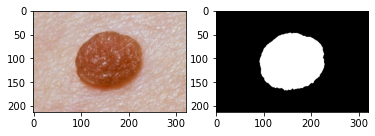

In [4]:
imname = "Images/FirstImages/HealthyMole.jpg"
print(assymetry(imname))

89840
This object is not simmetric
True


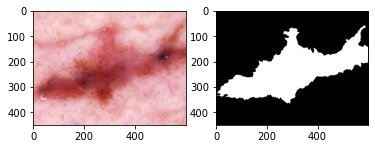

In [5]:
imname = "Images/FirstImages/ISIC_0024940.png"
print(assymetry(imname))

### Benchmark

In [3]:
import os, sys
import matplotlib.pyplot as plt


path = "Images/FirstImages"
dirs = os.listdir( path )
for file in dirs:
    if(not(assymetry("Images/FirstImages/"+file))):
        print(file)

HealthyMole.jpg


KeyboardInterrupt: 

### B - Border / Bordes
The border of the lesion. Melanomas may have borders that are vaguely defined. 

S. A. Mahdiraji, Y. Baleghi and S. M. Sakhaei, "BIBS, a New Descriptor for Melanoma/Non-Melanoma Discrimination," Electrical Engineering (ICEE), Iranian Conference on, 2018, pp. 1397-1402, doi: 10.1109/ICEE.2018.8472701.


The studied variables belonged to 4 categories: geometries, colors, textures, and islands of color (ie, color clusters inside the lesion). Geometries includes area, perimeter, maximum and minimum diameters, variance of contour symmetry, circularity, and fractality of borders. - https://jamanetwork.com/journals/jamadermatology/article-abstract/478127 (referencia para los bordes y las variables que se miden)

New approach to measure border irregularity for melanocytic lesions - https://www.researchgate.net/publication/252820346_New_approach_to_measure_border_irregularity_for_melanocytic_lesions (Alternativa a dimensiones fractales, leer)

Automatic detection of irregular borders in melanoma and other skin tumors: https://www.sciencedirect.com/science/article/abs/pii/089561119290074J (esperando a que me responan no tengo acceso)

FRACTALES:

Dimensiones fractales sirve solo para ver cuan irregular es, solo me dice cuantos "picos" tiene.
De donde tomé la idea.
https://ieeexplore-ieee-org.ezproxy.itcr.ac.cr/document/5627296 - Characterization of border structure using fractal dimension in melanomas
Ejemplo similar en código: https://stackoverflow.com/questions/44793221/python-fractal-box-count-fractal-dimension

https://ieeexplore-ieee-org.ezproxy.itcr.ac.cr/document/320544 - Diagnosis of melanoma with fractal dimensions

https://ieeexplore-ieee-org.ezproxy.itcr.ac.cr/document/5516958 - Comparative Study on Boundary Structural Irregularity Using Local FD and Curvature Analysis for Melanoma Detection

https://ieeexplore-ieee-org.ezproxy.itcr.ac.cr/document/8633651 - Features for Melanoma Lesions Characterization in Computer Vision Systems

In [50]:
import cv2 #Image Library
import numpy as np #Numpy library
import matplotlib.pyplot as plt #matplotlib to show images
import statistics
import imutils
from statistics import mean

def border_definition(imageName):
    image = cv2.imread(imageName) #read the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Same image but in grayscale, this is done for calculating the threshold
    ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#     _,thresh1 = cv2.threshold(gray,ret+5,255,cv2.THRESH_BINARY_INV)
#     _,thresh2 = cv2.threshold(gray,ret-5,255,cv2.THRESH_BINARY_INV)
    _,thresh_high = cv2.threshold(gray,ret+ret*0.1,255,cv2.THRESH_BINARY_INV)
    _,thresh_low = cv2.threshold(gray,ret-ret*0.1,255,cv2.THRESH_BINARY_INV)
    xor = cv2.bitwise_xor(thresh_high, thresh_low)
    
    return cv2.countNonZero(xor)
    

#     hist = cv2.calcHist(gray,[0],None,[256],[0,256])
#     f, axarr = plt.subplots(4,2,figsize=(14, 6)) #row,column
#     axarr[0,0].imshow(gray,cmap='gray', vmin=0, vmax=255)
#     axarr[0,1].plot(hist) #show threshold
#     axarr[1,0].imshow(thresh,cmap='gray', vmin=0, vmax=255) #show threshold
#     axarr[1,1].imshow(xor,cmap='gray', vmin=0, vmax=255) #show threshold
#     axarr[2,0].imshow(thresh1,cmap='gray', vmin=0, vmax=255) #show threshold
#     axarr[2,1].imshow(thresh2,cmap='gray', vmin=0, vmax=255) #show threshold
#     axarr[3,0].imshow(thresh_high,cmap='gray', vmin=0, vmax=255) #show threshold
#     axarr[3,1].imshow(thresh_low,cmap='gray', vmin=0, vmax=255) #show threshold

    
# testtrsh('Images/FirstImages/ISIC_0025313.png')
# testtrsh('Images/FirstImages/ISIC_0024961.png')
# testtrsh('Images/FirstImages/ISIC_0024545.png')
# testtrsh('Images/FirstImages/ISIC_0024930.png')

In [47]:
# -----------------------------------------------------------------------------
# From https://en.wikipedia.org/wiki/Minkowski–Bouligand_dimension:
#
# In fractal geometry, the Minkowski–Bouligand dimension, also known as
# Minkowski dimension or box-counting dimension, is a way of determining the
# fractal dimension of a set S in a Euclidean space Rn, or more generally in a
# metric space (X, d).
# -----------------------------------------------------------------------------

#Tomado de https://gist.github.com/viveksck/1110dfca01e4ec2c608515f0d5a5b1d1

import numpy as np
import cv2 #Image Library
import matplotlib.pyplot as plt #matplotlib to show images
import statistics
import imutils
from statistics import mean


def fractal_dimension(Z, threshold=0.9):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

def binary(imageName):
    image = cv2.imread(imageName) #read the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY ) #Same image but in grayscale, this is done for calculating the threshold
    ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    #get contours
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #fill in the contour
    cv2.drawContours(thresh, contours, -1, (255,255,255), thickness=cv2.FILLED)
    #find largest area contour and remove the smaller ones
    max_area = -1
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area>max_area:
            max_cont = contours[i]
            max_area = area
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if (area < max_area):
            cv2.drawContours(thresh, contours, -1, (0,0,0), 3)
    return thresh

# imname = "Images/FirstImages/ISIC_0024792.png" #Tener un valor medio
# I = binary(imname)

# imname = "Images/FirstImages/line.png" #Deberia tener un valor menos alto
# K = binary(imname)

# imname = "Images/FirstImages/assymetrytest.png" #Valor bajo
# J = binary(imname)


# print("Minkowski–Bouligand dimension (computed): ", fractal_dimension(I))
# print("Haussdorf dimension (theoretical):        ", (np.log(3)/np.log(2)))
# print("Minkowski–Bouligand dimension (computed): ", fractal_dimension(J))
# print("Haussdorf dimension (theoretical):        ", (np.log(3)/np.log(2)))
# print("Minkowski–Bouligand dimension (computed): ", fractal_dimension(K))
# print("Haussdorf dimension (theoretical):        ", (np.log(3)/np.log(2)))

In [51]:
import os, sys
import matplotlib.pyplot as plt


path = "Images/FirstImages/"
dirs = os.listdir( path )
for file in dirs:
    imname= "Images/FirstImages/"+file
    b = binary(imname)
    print("File: ",file," Border_def:" , border_definition(imname)," fd:",fractal_dimension(b))      


File:  assymetrytest.png  Border_def: 0  fd: 0.9490589561750855
File:  fractaltest.png  Border_def: 573  fd: 1.333388406016725
File:  HealthyMole.jpg  Border_def: 1795  fd: 0.9677110622952196
File:  ISIC_0024310.png  Border_def: 22572  fd: 1.1607139736998322
File:  ISIC_0024315.png  Border_def: 20295  fd: 1.072943776919267
File:  ISIC_0024351.png  Border_def: 47952  fd: 1.0905039419938436
File:  ISIC_0024449.png  Border_def: 57484  fd: 1.2421202193228555
File:  ISIC_0024482.png  Border_def: 49761  fd: 1.16332106189716
File:  ISIC_0024496.png  Border_def: 12582  fd: 0.9816803357790093
File:  ISIC_0024545.png  Border_def: 23633  fd: 1.1536742450816582
File:  ISIC_0024552.png  Border_def: 44533  fd: 1.124495374577525
File:  ISIC_0024630.png  Border_def: 56965  fd: 1.2220364809162916
File:  ISIC_0024640.png  Border_def: 13069  fd: 1.072697988714225
File:  ISIC_0024688.png  Border_def: 8700  fd: 1.0049335718729022
File:  ISIC_0024701.png  Border_def: 34238  fd: 1.1163385615111667
File:  ISI

### C - Colour / Color
Multiple colours are a warning sign. It is considered one of the early warning signs. While benign moles are usually a single shade of brown, a melanoma may have different shades of colour, this is called variegation. This is the key for determining the C factor in ABCD.

El código de color es producto de esta investgación. No se ha probado, por lo cual no se recomienda el uso de este hasta que se haya probado de una manera más completa. Sin embargo, ha funcionado para esta investgación y se continuará utilizando.

The process of images under this category consists of 3 main parts. First we apply a threshold to the images as to get a binary mask(representation) of the lesion. To this mask we must reapply the original image, this is the second part. The last step is to use a histogram of the H (as in HSV) value which represents the variation of the image. It doesn´t matter the value individually of each H value but the range of it, so we sum up if the current H value is greater than 0.

El proceso de colores consiste en 3 grandes partes. Primeramente se le debe aplicar una máscara binaria a la imagen, para que se separe la lesión de la piel sana (enmascaramiento). Una vez que se tiene la máscara se le devuelve el color a la lesión. El último paso es hacer un histograma de la nueva imagen. Para este se toma solo el valor H de SV en cuenta. No importa el tanto hay de un valor H individualmente, sino cuantos valores H hay. Se hace una sumatoria de todos los valores mayores a 0.

Examples, Ejemplos:
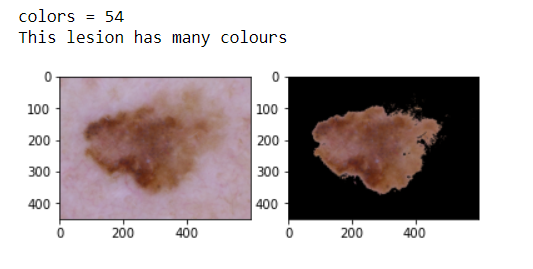
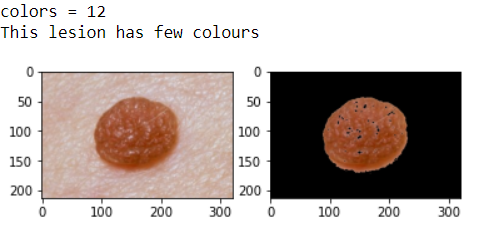
 

Se ha elegido el espacio de colores HSV. Este ya que los métodos que utilizan ABCD fueron desarollados por médicos utilizando la vista humana[1]. Al cual HSV se aproxima, en contraste con el RGB el cuál toma los datos de una manera muy distinta para ser práctica en esta aplicación. Se ha tomado en cuenta el espacio representativo CIELab[4].


L. Shuhua and G. Gaizhi, "The application of improved HSV color space model in image processing," 2010 2nd International Conference on Future Computer and Communication, 2010, pp. V2-10-V2-13, doi: 10.1109/ICFCC.2010.5497299.

16.2.3 The HSV Color Model - Oge Marques - Practical image and video processing using MATLAB® (2011, Wiley-IEEE Press)

[1]Shalu and A. Kamboj, "A Color-Based Approach for Melanoma Skin Cancer Detection," 2018 First International Conference on Secure Cyber Computing and Communication (ICSCCC), 2018, pp. 508-513, doi: 10.1109/ICSCCC.2018.8703309.


Mejoras: Convertir a CIELab - [4]S. Sabbaghi, M. Aldeen, R. Garnavi, G. Varigos, C. Doliantis and J. Nicolopoulos, "Automated colour identification in melanocytic lesions," 2015 37th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), 2015, pp. 3021-3024, doi: 10.1109/EMBC.2015.7319028.

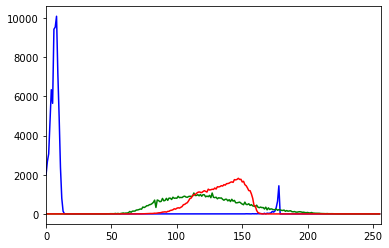

colors = 54
This lesion has many colours


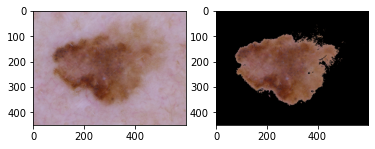

In [5]:
import cv2 #Image Library
import numpy as np #Numpy library
import matplotlib.pyplot as plt #matplotlib to show images

def colour(imageName):
    image = cv2.imread(imageName) #read the image
    [h,w,_] = image.shape #get width and length of the image
    
    roi = image[0:h, 0:w]

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Same image but in grayscale, this is done for calculating the threshold
    _,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    mask_inv = cv2.bitwise_not(thresh) #invert it and transform it to a bitwise image, so it's easier to use
    masked = cv2.bitwise_and(roi,roi,mask = mask_inv) #do and between the two
    masked = cv2.cvtColor(masked, cv2.COLOR_BGR2HSV)
    
    #get the size of the mask
    size = 0
    for x in range(h):
        for y in range(w):
            if(mask_inv[x][y] > 0):
                size +=1
    
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([masked],[i],None,[256],[1,256])
        plt.plot(histr,col)
        plt.xlim([0,256])
    plt.show()
    
    histr = cv2.calcHist([masked],[0],None,[256],[1,256])
    colors = 0
    for i in histr:
        if(i > 0):
            colors += 1
    print("colors = "+str(colors))    
    if (colors > 20):
        print("This lesion has many colours")
    else:
        print("This lesion has few colours")
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    masked = cv2.cvtColor(masked, cv2.COLOR_HSV2RGB)
    
    f, axarr = plt.subplots(1,2) #row,column
    axarr[0].imshow(image,cmap='hsv', vmin=0, vmax=255)
    axarr[1].imshow(masked,cmap='hsv', vmin=0, vmax=255) #mask
    
    
imname = "Images/FirstImages/ISIC_0024792.png" #Name of the image to analyze, it uses relative pathing for image path
colour(imname)

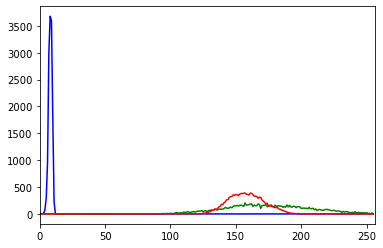

colors = 12
This lesion has few colours


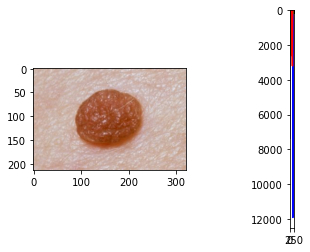

colors = 87
This lesion has many colours


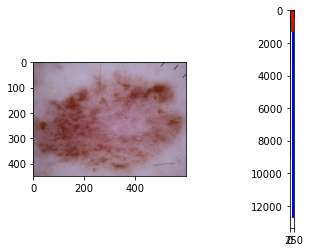

colors = 32
This lesion has many colours


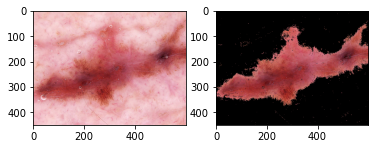

In [6]:
imname = "Images/FirstImages/HealthyMole.jpg"
colour(imname)

imname = "Images/FirstImages/ISIC_0024961.png"
colour(imname)

imname = "Images/FirstImages/ISIC_0024940.png"
colour(imname)

### D - Dimension / Dimensión

Los melanomas son comunmente más largos que 6mm [1]. Esto es desde una línea recta.

Usualmente el estimar un tamaño de un objeto dentro de una foto es complicado o imposible. Pero, en este proyecto se utilizó una herramienta con el proposito de estandarizar las dimensiones de las fotografías. De manera que se puede obtener cuanto es el tamaño de un solo pixel. Por lo tanto, es posible tomar las dimensiones de las lesiónes.

Se ha determinado que un pixel con utilizando la herramienta es de __ mm. 


Conociendo el tamaño de cada pixel, es posible tomar el código previamente desarrollado de la máscara y determinar el area de una lesión. Esto por medio de contar pixeles que sean blancos. Una vez que se obtienen la cantidad de pixeles blancos se puede multiplar la cantidad de pixeles por el area que cada uno ocupa. Así determinando el área de la lesión.


Teniendo un tamaño de lesión se puede comparar con la métrica de 6mm previemente mencionada y determinar si el tamaño es de riesgo o no. 

[1]Crovari Eulufi, F., & Manzor Véliz, M. (2014). Manual de patología quirúrgica. Universidad Católica de Chile. https://www-digitaliapublishing-com.ezproxy.itcr.ac.cr/a/3826

68384

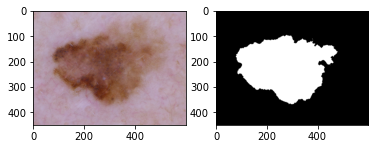

In [1]:
import cv2 #Image Library
import numpy as np #Numpy library
import matplotlib.pyplot as plt #matplotlib to show images

size_of_pixel = 1

def dimension(imageName):
    image = cv2.imread(imageName) #read the image
    [h,w,_] = image.shape #get width and length of the image
    
    roi = image[0:h, 0:w]

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Same image but in grayscale, this is done for calculating the threshold
    _,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    #get contours
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #fill in the contour
    cv2.drawContours(thresh, contours, -1, (255,255,255), thickness=cv2.FILLED)
    #find largest area contour and remove the smaller ones
    max_area = -1
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area>max_area:
            max_cont = contours[i]
            max_area = area
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if (area < max_area):
            cv2.drawContours(thresh, contours, -1, (0,0,0), 3)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    f, axarr = plt.subplots(1,2) #row,column
    axarr[0].imshow(image,cmap='hsv', vmin=0, vmax=255)
    axarr[1].imshow(thresh,cmap='gray', vmin=0, vmax=255)
    
    tot = 0
    for y in range(h):
        for x in range(w):
            if(thresh[y][x]) == 255:
                tot +=1
    global size_of_pixel
    return tot * size_of_pixel
            
    
imname = "Images/FirstImages/ISIC_0024792.png" #Name of the image to analyze, it uses relative pathing for image path
dimension(imname)

Cutaneous Melanoma - Medical Progress - KOH - Util para referencia de caracterisitcas de ABCD

